In [520]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import qiskit
from qiskit.visualization import array_to_latex

# Primitive MCMC

In [499]:
n = 5
T = 4

In [500]:
def int_to_bin(i, n=None):
    'Convert a given integer to a bitstring of fixed length'
    if n is not None:
        return bin(i)[2:].zfill(n)
    else: return bin(i)[2:]
    
def bin_to_int(s):
    'Convert a given bitstring to integer'
    return int(s,2)

def random_bitstring(n):
    i = np.random.randint(0,2**n)
    return int_to_bin(i, n)

In [501]:
def E(s):
    'Simple energy function'
    if type(s) == type('s'): i = bin_to_int(s)
    else: i = s
    return -np.exp(-(i-16)**2/16)

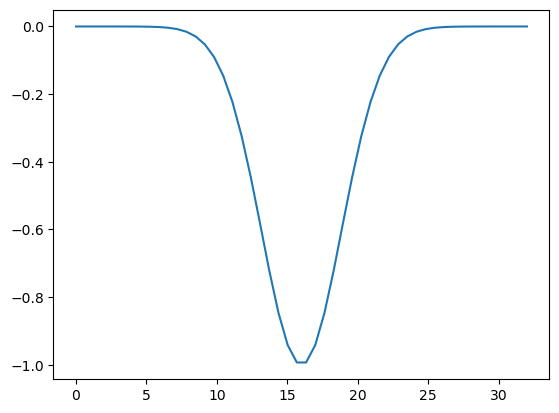

In [502]:
plt.plot(np.linspace(0,32), [E(s) for s in np.linspace(0,32)])

In [503]:
def propose_random():
    '''Propose a random bitstring of length n.'''
    return random_bitstring(n)

def accept(s,s_new,energy_func):
    '''Determine acceptance based on Metropolis criterion.'''
    A = min(1, np.exp((energy_func(s)-energy_func(s_new)) / T))
    if A >= np.random.uniform(0,1): return True
    else: return False

In [504]:
def samples_to_counts(samples, dtype='str'):
    'Convert sample list to a dictionary of counts'
    counts = {}
    if dtype == 'str':
        for sample in samples:
            if sample in counts: counts[sample] += 1
            else: counts[sample] = 1
    if dtype == 'int':
        for sample in samples:
            if bin_to_int(sample) in counts: counts[bin_to_int(sample)] += 1
            else: counts[bin_to_int(sample)] = 1  
    return counts

In [505]:
samples = []
for i in range(1000):
    s = random_bitstring(n)
    for iter in range(100):
        s_new = propose_random()
        if accept(s, s_new, energy_func = E): s = s_new
    samples.append(s)

counts = samples_to_counts(samples, dtype='int')

<BarContainer object of 32 artists>

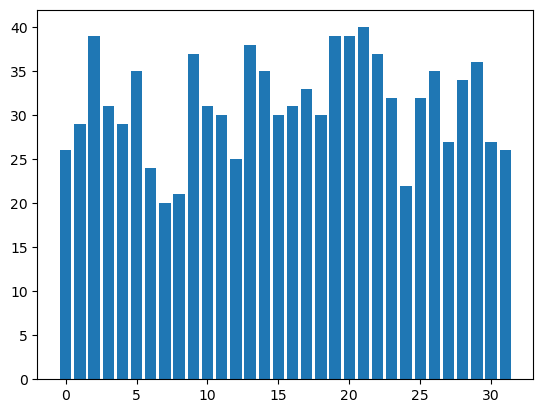

In [506]:
x,y = zip(*counts.items())
plt.bar(x,y)

# Random Ising model

In [524]:
n = 5
T = 4

In [525]:
def bin_to_spin(s):
    if len(s) == 1: return 2*int(s)-1
    else:
        l = [2*int(c)-1 for c in s]
        return l

def generate_random_J(n):
    '''Generate a random symmetric coupling matrix for n sites sampled from N(0,1).'''
    J = np.random.standard_normal((n, n))
    J = 0.5 * (J + J.T)  # Ensure symmetry
    np.fill_diagonal(J, 0)  # No self-interactions
    return J

def generate_random_h(n):
    '''Generate random external fields for n sites sampled from N(0,1).'''
    return np.random.standard_normal(n)

def E_ising(s, J, h):
    ''''Calculate the energy of a spin configuration.'''
    energy = 0
    n = len(s)
    if type(s) == type('s'): s = bin_to_spin(s)
    # Interaction term
    for i in range(n):
        for j in range(i + 1, n):
            energy += -J[i, j] * s[i] * s[j]
    # External field term
    for i in range(n):
        energy += -h[i] * s[i]

    return energy

In [526]:
J = generate_random_J(n)
h = generate_random_h(n)

In [527]:
samples = []
for i in range(1000):
    s = random_bitstring(n)
    for iter in range(100):
        s_new = propose_random()
        if accept(s, s_new, energy_func = lambda x: E_ising(x, J, h)): s = s_new
    samples.append(s)

counts = samples_to_counts(samples, dtype='int')

<BarContainer object of 32 artists>

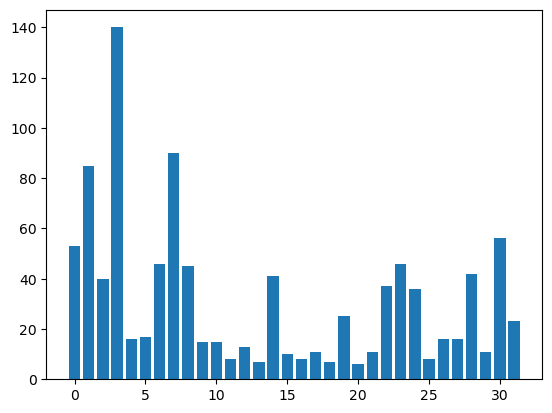

In [528]:
x,y = zip(*counts.items())
plt.bar(x,y)

# Extracting spectral gap

In [557]:
def get_P_matrix_random(n, energy_func):
    P = np.zeros((2**n, 2**n))
    p_propose = 1/2**n
    for i in range(2**n):
        s_i = int_to_bin(i,n)
        for j in range(2**n):
            s_j = int_to_bin(j,n)
            A = min(1, np.exp((energy_func(s_i)-energy_func(s_j)) / T))
            P[i,j] = A*p_propose
    return P

In [558]:
P_random = get_P_matrix_random(n, lambda x: E_ising(x, J, h))

In [575]:
vals, vecs = scipy.sparse.linalg.eigs(P_random)

In [576]:
vals

array([0.68300905+0.j, 0.14915844+0.j, 0.05690981+0.j, 0.03080845+0.j,
       0.01613294+0.j, 0.01299858+0.j])

In [561]:
array_to_latex(P_random)

<IPython.core.display.Latex object>

In [565]:
P_random[:32,0]

array([0.03125   , 0.01742755, 0.02962541, 0.0116889 , 0.03125   ,
       0.03125   , 0.02560223, 0.01838865, 0.03125   , 0.03125   ,
       0.03125   , 0.03125   , 0.03125   , 0.03125   , 0.03125   ,
       0.03125   , 0.03125   , 0.03125   , 0.03125   , 0.03125   ,
       0.03125   , 0.03125   , 0.03125   , 0.03125   , 0.03125   ,
       0.03125   , 0.03125   , 0.03125   , 0.03125   , 0.03125   ,
       0.02137098, 0.03125   ])

In [568]:
sum(P_random[:32,0])

0.9366037013798121

In [577]:
import numpy as np
import matplotlib.pyplot as plt

# Target distribution (unnormalized) - 1D Gaussian
def target_distribution(x):
    return np.exp(-0.5 * x**2)

# Metropolis-Hastings algorithm
def metropolis_hastings(initial_state, num_samples, proposal_std):
    samples = [initial_state]

    for _ in range(num_samples):
        current_state = samples[-1]

        # Propose a new state using a normal distribution
        proposed_state = current_state + np.random.normal(scale=proposal_std)

        # Calculate acceptance probability
        acceptance_prob = min(1, target_distribution(proposed_state) / target_distribution(current_state))

        # Accept or reject the proposed state
        if np.random.uniform(0, 1) < acceptance_prob:
            samples.append(proposed_state)
        else:
            samples.append(current_state)

    return np.array(samples)

# Calculate the transition matrix
def calculate_transition_matrix(samples):
    unique_states, counts = np.unique(samples, return_counts=True)
    num_states = len(unique_states)
    transition_matrix = np.zeros((num_states, num_states))

    for i, state in enumerate(unique_states):
        next_state_indices = np.where(samples[:-1] == state)[0] + 1
        next_states = samples[next_state_indices]

        for j, next_state in enumerate(unique_states):
            transition_matrix[i, j] = np.sum(next_states == next_state) / counts[i]

    return unique_states, transition_matrix

# Calculate eigenvalues of the transition matrix
def calculate_eigenvalues(transition_matrix):
    v,_ = scipy.sparse.linalg.eigs(transition_matrix)
    return v

# Example usage
initial_state = 0.0
num_samples = 1000
proposal_std = 0.5

samples = metropolis_hastings(initial_state, num_samples, proposal_std)
unique_states, transition_matrix = calculate_transition_matrix(samples)
eigenvalues = calculate_eigenvalues(transition_matrix)

# Display the eigenvalues
print("Eigenvalues of the transition matrix:")
print(eigenvalues)

# Plot the results
plt.hist(samples, bins=50, density=True, alpha=0.5, label='MCMC Samples')
x_values = np.linspace(-3, 3, 100)
plt.plot(x_values, target_distribution(x_values), label='Target Distribution', color='red')
plt.legend()
plt.title('Metropolis-Hastings MCMC')
plt.xlabel('Sampled Values')
plt.ylabel('Probability Density')
plt.show()


ArpackNoConvergence: ARPACK error -1: No convergence (8451 iterations, 0/6 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]

In [ ]:
eigenvalues[0]

0.0